In [1]:
import os
from dotenv import load_dotenv
import vanna
from vanna.openai import OpenAI_Chat
from vanna.chromadb import ChromaDB_VectorStore
from vanna.flask import VannaFlaskApp

In [10]:
load_dotenv()

True

In [11]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        if config is None:
            config = {}

        # Ensure the API key is set in the config
        api_key = os.getenv('OPENAI_API_KEY')
        if api_key:
            config['api_key'] = api_key
        else:
            raise ValueError("API key not found. Ensure the .env file contains the OPENAI_API_KEY.")

        # Initialize the parent classes with the config
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)


vn = MyVanna(config={'model': 'gpt-4o'})

In [12]:
vn.connect_to_mysql(host=os.getenv('DB_HOST'),
                    dbname=os.getenv('DB_NAME'),
                    user=os.getenv('DB_USER'),
                    password=os.getenv('DB_PASSWORD'),
                    port=3306)

In [13]:
df_information_schema = vn.run_sql("""
    SELECT *
    FROM INFORMATION_SCHEMA.TABLES
    WHERE TABLE_SCHEMA = 'inventory'
""")

In [14]:
# Generate the training plan
plan = vn.get_training_plan_generic(df_information_schema)

In [15]:
for table_name in plan.get_summary():
    print(table_name)

Train on Information Schema: def.inventory item
Train on Information Schema: def.inventory item_price
Train on Information Schema: def.inventory item_stock
Train on Information Schema: def.inventory stockroom


In [16]:
vn.train(plan=plan)

C:\Users\jmutonyi\.cache\chroma\onnx_models\all-MiniLM-L6-v2\onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:21<00:00, 3.81MiB/s]


### Train on DDL

In [17]:
vn.train(ddl = """
CREATE TABLE IF NOT EXIST item (
item_id INT PRIMARY KEY,
item_name VARCHAR(150),
item_description VARCHAR(150),
department_id INT,
default_price_id INT,
has_expiration INT,
concept_id INT,
creator INT,
date_created DATETIME,
changed_by INT,
date_changed DATETIME,
retired INT,
retired_by INT,
date_retired DATETIME,
retire_reason VARCHAR(50),
uuid VARCHAR(100),
has_physical_inventory INT,
default_expiration_period INT,
concept_accepted INT,
minimun_quantity INT,
buying_price DOUBLE         
)
""")

Adding ddl: 
CREATE TABLE IF NOT EXIST item (
item_id INT PRIMARY KEY,
item_name VARCHAR(150),
item_description VARCHAR(150),
department_id INT,
default_price_id INT,
has_expiration INT,
concept_id INT,
creator INT,
date_created DATETIME,
changed_by INT,
date_changed DATETIME,
retired INT,
retired_by INT,
date_retired DATETIME,
retire_reason VARCHAR(50),
uuid VARCHAR(100),
has_physical_inventory INT,
default_expiration_period INT,
concept_accepted INT,
minimun_quantity INT,
buying_price DOUBLE         
)



'210394dd-edc6-52a7-b4f1-73a18ad91c74-ddl'

### Train on Documentation

In [18]:
vn.train(documentation="This contains item inventory on a healthcare platform such as the item name, buying price, and whether it has physical inventory.")

Adding documentation....


'8e4d7f3f-0810-5409-ba8a-1419b60a6f31-doc'

### Train on SQL query

In [19]:
vn.train(question="What are the item names of the items that do not have physical inventory?",
         sql = "SELECT item_name * FROM item WHERE has_physical_inventory = 0'")

'20410a26-2b10-562d-969f-e3e02000eb1a-sql'

In [20]:
vn.train(sql = "SELECT item_name * FROM item WHERE has_physical_inventory = 1'")

Using model gpt-4o for 69.0 tokens (approx)
Question generated with sql: Which items have physical inventory? 
Adding SQL...


'f9313fb2-eff9-57f6-bc63-b393c9ccb66e-sql'

In [21]:
vn.train(question="What is the average price of items with physical inventory and those without",
         sql="SELECT has_physical_inventory,AVG(price) AS average_price FROM item INNER JOIN item_price ON item.default_price_id = item_price.item_price_id GROUP BY has_physical_inventory")

'54f1c3e5-e58f-55f8-88bd-790941844a25-sql'

In [22]:
vn.train(question="Which storeroom has the most inventory?",
        sql="SELECT item_stock.stockroom_id, stockroom_name, SUM(item_stock.quantity) AS total_quantity FROM item_stock INNER JOIN stockroom ON item_stock.stockroom_id = stockroom.stockroom_id GROUP BY item_stock.stockroom_id, stockroom_name ORDER BY total_quantity DESC LIMIT 1")

'b7a6a598-0a53-519d-b225-9b6d8cbc4613-sql'

In [23]:
vn.train(question="What items are running out of stock? Items that have a quantity of less than 10",
        sql="SELECT item.item_id, item.item_id, quantity FROM item_stock INNER JOIN item ON item_stock.item_id = item.item_id WHERE quantity < 10 ORDER BY quantity DESC")

'1dc51e38-9266-5912-8f3f-69bc3e2a1d0e-sql'

In [24]:
vn.get_training_data()

,id,question,content,training_data_type
0,1dc51e38-9266-5912-8f3f-69bc3e2a1d0e-sql,What items are running out of stock? Items tha...,"SELECT item.item_id, item.item_id, quantity FR...",sql
1,20410a26-2b10-562d-969f-e3e02000eb1a-sql,What are the item names of the items that do n...,SELECT item_name * FROM item WHERE has_physica...,sql
2,54f1c3e5-e58f-55f8-88bd-790941844a25-sql,What is the average price of items with physic...,"SELECT has_physical_inventory,AVG(price) AS av...",sql
3,b7a6a598-0a53-519d-b225-9b6d8cbc4613-sql,Which storeroom has the most inventory?,"SELECT item_stock.stockroom_id, stockroom_name...",sql
4,f9313fb2-eff9-57f6-bc63-b393c9ccb66e-sql,Which items have physical inventory?,SELECT item_name * FROM item WHERE has_physica...,sql
0,210394dd-edc6-52a7-b4f1-73a18ad91c74-ddl,None,\nCREATE TABLE IF NOT EXIST item (\nitem_id IN...,ddl
0,0879b86a-031b-538e-b161-1520ca5b0a13-doc,None,The following columns are in the item_stock ta...,documentation
1,47b97fd5-c67b-5436-8512-6db5f57c5de7-doc,None,The following columns are in the item_price ta...,documentation
2,68182647-9045-5c87-93d1-bd4a7f9f7c55-doc,None,The following columns are in the stockroom tab...,documentation
3,851dc5c3-69a7-531f-9c06-96426e29d5ed-doc,None,The following columns are in the item table in...,documentation


Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5


SQL Prompt: [{'role': 'system', 'content': "You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\nCREATE TABLE IF NOT EXIST item (\nitem_id INT PRIMARY KEY,\nitem_name VARCHAR(150),\nitem_description VARCHAR(150),\ndepartment_id INT,\ndefault_price_id INT,\nhas_expiration INT,\nconcept_id INT,\ncreator INT,\ndate_created DATETIME,\nchanged_by INT,\ndate_changed DATETIME,\nretired INT,\nretired_by INT,\ndate_retired DATETIME,\nretire_reason VARCHAR(50),\nuuid VARCHAR(100),\nhas_physical_inventory INT,\ndefault_expiration_period INT,\nconcept_accepted INT,\nminimun_quantity INT,\nbuying_price DOUBLE         \n)\n\n\n\n===Additional Context \n\nThe following columns are in the stockroom table in the def database:\n\n|    | TABLE_CATALOG   | TABLE_SCHEMA   | TABLE_NAME   | TABLE_COMMENT   |\n|---:|:----------------|:---------------|

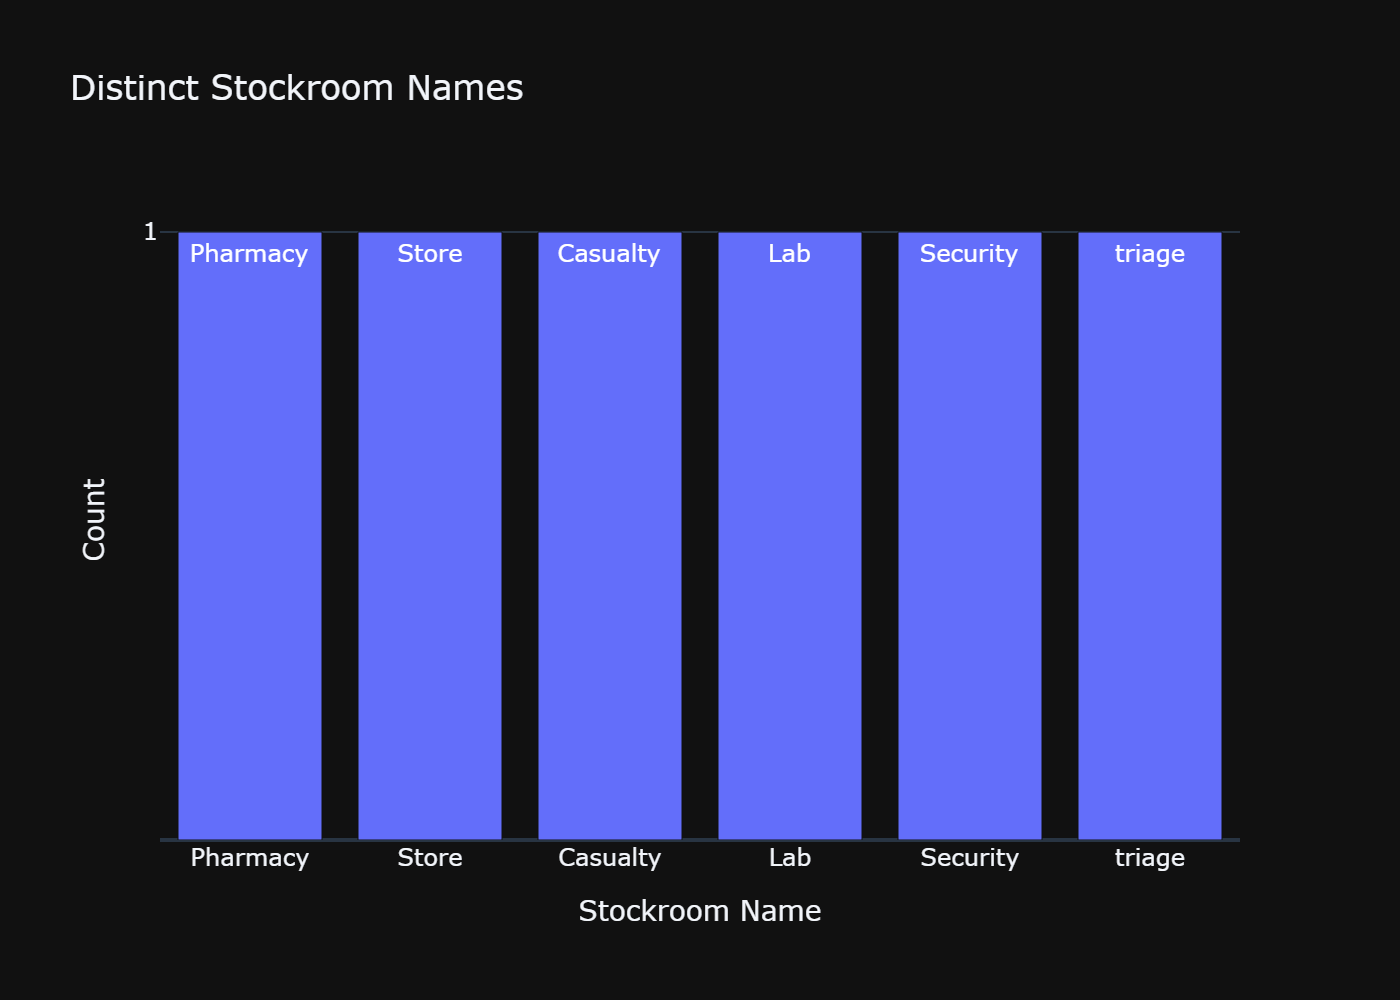

('SELECT DISTINCT stockroom_name FROM stockroom;',
   stockroom_name
 0       Pharmacy
 1          Store
 2       Casualty
 3            Lab
 4       Security
 5         triage,
 Figure({
     'data': [{'text': array(['Pharmacy', 'Store', 'Casualty', 'Lab', 'Security', 'triage'],
                             dtype=object),
               'textposition': 'auto',
               'type': 'bar',
               'x': array(['Pharmacy', 'Store', 'Casualty', 'Lab', 'Security', 'triage'],
                          dtype=object),
               'y': [1, 1, 1, 1, 1, 1]}],
     'layout': {'template': '...',
                'title': {'text': 'Distinct Stockroom Names'},
                'xaxis': {'title': {'text': 'Stockroom Name'}},
                'yaxis': {'ticktext': ['1'], 'tickvals': [1], 'title': {'text': 'Count'}}}
 }))

In [25]:
vn.ask("can you give me distinct stockroom names from stockroom table?", allow_llm_to_see_data=True)

In [27]:
app = VannaFlaskApp(vn, allow_llm_to_see_data=True)
app.run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on


Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5


Using model gpt-4o for 999.25 tokens (approx)
Using model gpt-4o for 3266.25 tokens (approx)


Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5


Using model gpt-4o for 988.5 tokens (approx)
Using model gpt-4o for 142.0 tokens (approx)


Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5


Using model gpt-4o for 1002.75 tokens (approx)
